In [1]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import random
from torchvision import transforms
import math 
import matplotlib.pyplot as plt
from scipy.fft import fft, rfft, irfft, ifft,fftshift, fft2, ifft2, dct, idct
from scipy.ndimage.filters import gaussian_filter
from PIL import Image, ImageCms

In [28]:
def fft_magitude(img, shift: bool=True):
    if isinstance(img, np.ndarray):
        img_tensor = torch.from_numpy(img)
    else:
        img_tensor = img
    fft_img = torch.fft.fft2(img_tensor, norm="forward")
    fft_img_magnitude = torch.abs(fft_img)
    if shift:
        fft_img_magnitude = torch.fft.fftshift(fft_img_magnitude)
    return fft_img_magnitude

In [18]:
def get_random_spike_signals(n_spikes: int = 1, 
                             img_size: int = 32, 
                             min_dist: int = 4, 
                             sigma: float = 1.0, 
                             add_gauss_noise: float = 0.0125):
    img_spikes = np.zeros((img_size, img_size))
    spikes_coord = np.random.randint(1, int((img_size-1)/min_dist), size=(n_spikes,2)) * min_dist
    for ind in range(spikes_coord.shape[0]):
        img_spikes[spikes_coord[ind, 0], spikes_coord[ind, 1]] =1.0
    if sigma > 0.0: 
        img_spikes = gaussian_filter(img_spikes, sigma)
    
    img_spikes = torch.from_numpy(img_spikes)
    
    if add_gauss_noise > 0.0:
        img_spikes = img_spikes + add_gauss_noise*torch.randn_like(img_spikes)
                            
    return img_spikes

In [22]:
img_spikes = get_random_spike_signals(4, 64, 8, sigma=0.0, add_gauss_noise=0.0)
img_spikes_smooth = get_random_spike_signals(4, 64, 8, add_gauss_noise=0.0)
img_spikes_smooth_noisy = get_random_spike_signals(4, 64, 8)
img_spikes_smooth_noisy.shape, img_spikes_smooth.shape

(torch.Size([64, 64]), torch.Size([64, 64]))

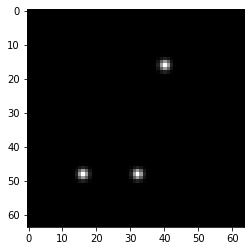

In [23]:
plt.imshow(img_spikes_smooth, cmap='gray', interpolation='none')

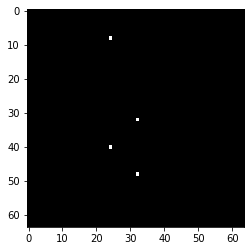

In [26]:
plt.imshow(img_spikes, cmap='gray', interpolation='none')

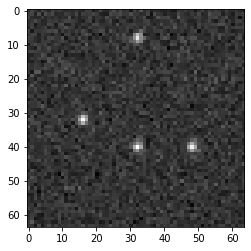

In [25]:
plt.imshow(img_spikes_smooth_noisy, cmap='gray', interpolation='none')

In [30]:
fft_img_spikes = fft_magitude(img_spikes)
fft_img_spikes_smooth = fft_magitude(img_spikes_smooth)
fft_img_spikes_smooth_noisy = fft_magitude(img_spikes_smooth_noisy)

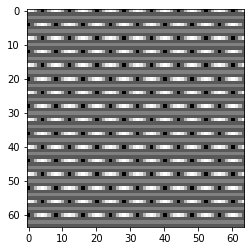

In [31]:
plt.imshow(fft_img_spikes, cmap='gray', interpolation='none')

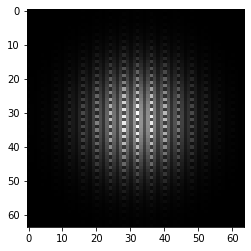

In [32]:
plt.imshow(fft_img_spikes_smooth, cmap='gray', interpolation='none')

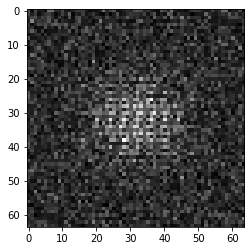

In [33]:
plt.imshow(fft_img_spikes_smooth_noisy, cmap='gray', interpolation='none')

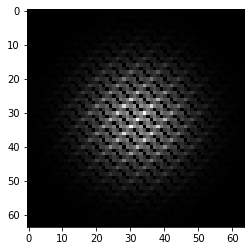

In [101]:
plt.imshow(fft_img_spikes_smooth0.abs(), cmap='gray', interpolation='none')

In [34]:
batch_size = 4
img_one_spike_batch = torch.stack([get_random_spike_signals(1, 64, 8, add_gauss_noise=0.0) 
                                   for _ in range(batch_size)])
img_one_spike_batch_noisy = torch.stack([get_random_spike_signals(1, 64, 8) for _ in range(batch_size)])
fft_one_spike_batch = fft_magitude(img_one_spike_batch)
fft_one_spike_batch_noisy = fft_magitude(img_one_spike_batch_noisy)

In [35]:
img_one_spike_batch.shape

torch.Size([4, 64, 64])

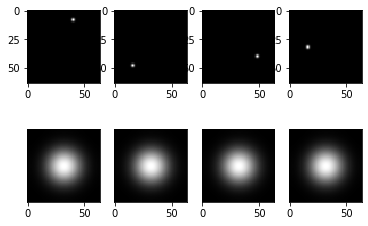

In [43]:
fig = plt.figure()
for i in range(batch_size):
    plt.subplot(2,batch_size,i+1)
    plt.imshow(img_one_spike_batch[i], cmap='gray', interpolation='none')
    plt.subplot(2,batch_size,1+batch_size + i)
    plt.imshow(fft_one_spike_batch[i], cmap='gray', interpolation='none')
    plt.yticks([])

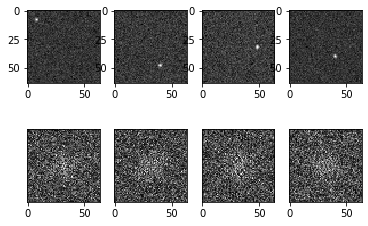

In [44]:
fig = plt.figure()
for i in range(batch_size):
    plt.subplot(2,batch_size,i+1)
    plt.imshow(img_one_spike_batch_noisy[i], cmap='gray', interpolation='none')
    plt.subplot(2,batch_size,1+batch_size + i)
    plt.imshow(fft_one_spike_batch_noisy[i], cmap='gray', interpolation='none')
    plt.yticks([])

In [73]:
batch_size = 4
spikes= 3
img_spikes_batch = torch.stack([get_random_spike_signals(spikes, 64, 8, add_gauss_noise=0.0) 
                                   for _ in range(batch_size)])
img_spikes_batch_noisy = torch.stack([get_random_spike_signals(spikes, 64, 8) for _ in range(batch_size)])

fft_spikes_batch = fft_magitude(img_spikes_batch)
fft_spikes_batch_noisy = fft_magitude(img_spikes_batch_noisy)

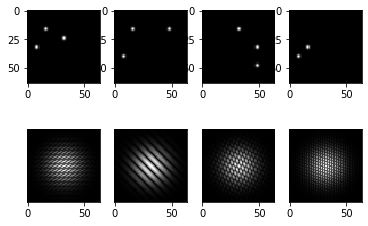

In [74]:
fig = plt.figure()
for i in range(batch_size):
    plt.subplot(2,batch_size,i+1)
    plt.imshow(img_spikes_batch[i], cmap='gray', interpolation='none')
    plt.subplot(2,batch_size,1+batch_size + i)
    plt.imshow(fft_spikes_batch[i], cmap='gray', interpolation='none')
    plt.yticks([])

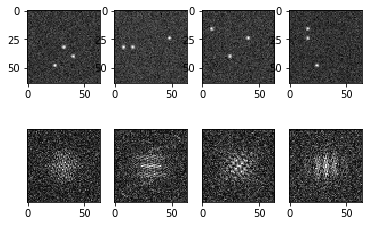

In [75]:
fig = plt.figure()
for i in range(batch_size):
    plt.subplot(2,batch_size,i+1)
    plt.imshow(img_spikes_batch_noisy[i], cmap='gray', interpolation='none')
    plt.subplot(2,batch_size,1+batch_size + i)
    plt.imshow(fft_spikes_batch_noisy[i], cmap='gray', interpolation='none')
    plt.yticks([])

In [76]:
img_spikes_batch_noisy[0].shape

torch.Size([64, 64])

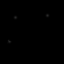

In [79]:
transforms.RandomRotation(5)(to_pil(img_spikes_batch[1]))

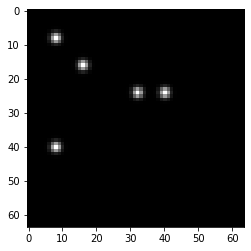

In [181]:
plt.imshow(img_spikes_smooth_batch[i], 
           cmap='gray', 
           interpolation='none')

In [55]:
def to_uint8(image: np.ndarray) -> np.ndarray:
    """
    Converts a float32 image to a uint8 image in the range [0, 255].
    :param image: The image to convert.
    :return: The converted uint8 image.
    """

#     typeguard.check_argument_types()
    if image.dtype == np.uint8:
        return image

    image_uint8 = np.asarray(image * 255, dtype='uint8')
    return image_uint8

In [56]:
def to_pil(image: np.ndarray) -> Image.Image:
    """
    Converts an np.ndarray image to PIL.Image.
    :param image: The image to convert.
    :return: The converted PIL image.
    """

    assert len(image.shape) in (2, 3), \
        f'Invalid image shape: {image.shape}. Shape must be of length 2 (greyscale) or 3 (RGB).'

    image_uint8 = to_uint8(image)
    image_uint8 = np.squeeze(image_uint8)  # for grayscale

    if len(image_uint8.shape) == 3:
        image_pil = Image.fromarray(image_uint8, 'RGB')
    else:
        image_pil = Image.fromarray(image_uint8, 'L')

    return image_pil

In [57]:

def to_float32(image: np.ndarray) -> np.ndarray:
    """
    Converts a uint8 image to a float32 image in the range [0, 1].
    :param image: The image to convert.
    :return: The converted float32 image.
    """

#     typeguard.check_argument_types()
    if image.dtype == np.float32:
        return image

    image_float32 = np.asarray(image, dtype='float32') / 255.0
    return image_float32

In [58]:
def from_pil(pil_image: Image.Image, convert_to_float32: bool = True) -> np.ndarray:
    """
    Converts a PIL.Image to an np.ndarray image.
    :param pil_image: A PIL.Image to convert.
    :param convert_to_float32: Whether or not to return the result as a float32 image in the range [0, 1].
    :return: The converted np.ndarray image.
    """

#     typeguard.check_argument_types()
    # noinspection PyTypeChecker
    np_image = np.array(pil_image)
    if convert_to_float32:
        np_image = to_float32(np_image)

    return np_image

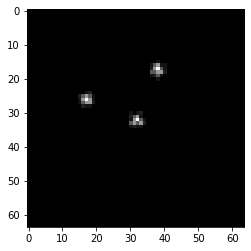

In [202]:
plt.imshow(transforms.RandomRotation(90)(to_pil(img_spikes_smooth_batch[1])), 
           cmap='gray', 
           interpolation='none')

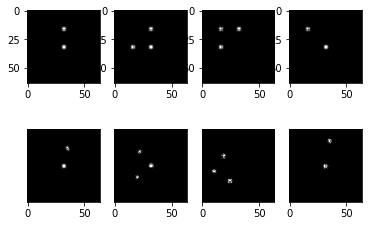

In [203]:
fig = plt.figure()
for i in range(batch_size):
    plt.subplot(2,batch_size,i+1)
    plt.imshow(img_spikes_smooth_batch[i], cmap='gray', interpolation='none')
    plt.subplot(2,batch_size,1+batch_size + i)
    plt.imshow(transforms.RandomRotation(90)(to_pil(img_spikes_smooth_batch[i])), cmap='gray', interpolation='none')
#   plt.title(f"{i}_Label: {example_targets[i]}")
    plt.yticks([])

In [205]:
img_smoth1 = img_spikes_smooth_batch[1]

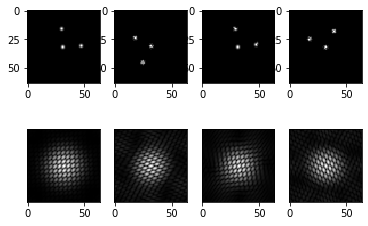

In [212]:
fig = plt.figure()
for i in range(batch_size):
    plt.subplot(2,batch_size,i+1)
    rot_img = from_pil(transforms.RandomRotation(90)(to_pil(img_smoth1)))
    plt.imshow(rot_img, cmap='gray', interpolation='none')
    plt.subplot(2,batch_size,1+batch_size + i)
    plt.imshow(fft_magitude(rot_img), cmap='gray', interpolation='none')
#   plt.title(f"{i}_Label: {example_targets[i]}")
    plt.yticks([])

In [218]:
siagme_noise = 0.25

In [239]:
r=10
phi = 0.1

<function _VariableFunctionsClass.polar>

In [240]:
np.pi

3.141592653589793

In [241]:
import cmath, math

In [60]:
def pol2cart(r, phi):
    x = r * np.cos(phi)
    y = r * np.sin(phi)
    return(x, y)


In [65]:
def get_random_spike_signals_polar(n_spikes: int = 1, 
                                   img_size: int = 32, 
                                   min_dist: int = 4, 
                                   sigma: float = 1.0, 
                                   add_gauss_noise: float = 0.0125):
    phi_ranges = 2*np.pi*np.arange(0, n_spikes, 1)/n_spikes
    half_size = img_size // 2
    r_ranges =( np.random.permutation(half_size-2*min_dist)+min_dist)[:n_spikes]
    x, y = pol2cart(r_ranges, phi_ranges)
    x += (half_size)
    y += (half_size)
    x = np.(np.round(x))
    y = np.int32(np.round(y))
    img_spikes = np.zeros((img_size, img_size))
    for ind in range(n_spikes):
        img_spikint32es[y[ind], x[ind]] =1.0
    if sigma > 0: 
        img_spikes = gaussian_filter(img_spikes, sigma)
    img_spikes = torch.from_numpy(img_spikes)
    if add_gauss_noise > 0.0:
        img_spikes = img_spikes + add_gauss_noise*torch.randn_like(img_spikes)
    
    return img_spikes, x, y

In [69]:
img_pol_spikes , x, y = get_random_spike_signals_polar(n_spikes=4, min_dist=4)

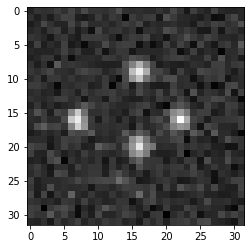

In [71]:
plt.imshow(img_pol_spikes, 
           cmap='gray', 
           interpolation='none')

In [89]:
batch_size = 4
spikes= 5
img_spikes_pol_batch = torch.stack([get_random_spike_signals_polar(spikes, 64, 8, add_gauss_noise=0.0)[0] 
                                   for _ in range(batch_size)])
img_spikes_pol_batch_noisy = torch.stack([get_random_spike_signals_polar(spikes, 64, 8)[0] 
                                      for _ in range(batch_size)])

fft_spikes_pol_batch = fft_magitude(img_spikes_pol_batch)
fft_spikes_pol_batch_noisy = fft_magitude(img_spikes_pol_batch_noisy)

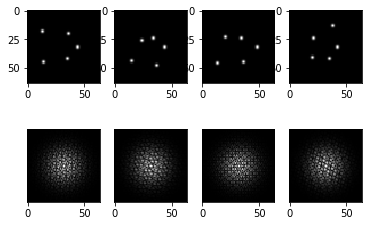

In [90]:
fig = plt.figure()
for i in range(batch_size):
    plt.subplot(2,batch_size,i+1)
    plt.imshow(img_spikes_pol_batch[i], cmap='gray', interpolation='none')
    plt.subplot(2,batch_size,1+batch_size + i)
    plt.imshow(fft_spikes_pol_batch[i], cmap='gray', interpolation='none')
    plt.yticks([])

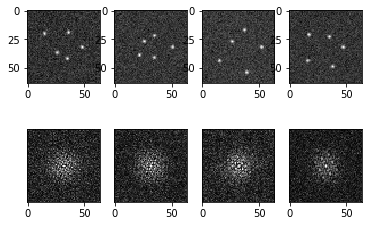

In [91]:
fig = plt.figure()
for i in range(batch_size):
    plt.subplot(2,batch_size,i+1)
    plt.imshow(img_spikes_pol_batch_noisy[i], cmap='gray', interpolation='none')
    plt.subplot(2,batch_size,1+batch_size + i)
    plt.imshow(fft_spikes_pol_batch_noisy[i], cmap='gray', interpolation='none')
    plt.yticks([])